<a href="https://colab.research.google.com/github/josematez/DeepLearning_SkinCancer/blob/main/DenseNet_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install deepdish
#!pip install numpy==1.15.4

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import deepdish as dd
#from tqdm import tqdm
#from glob import glob
#import seaborn as sns
#import pprint as pp

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import np_utils, to_categorical, plot_model
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam, RMSprop, SGD
from keras.preprocessing.image import ImageDataGenerator

#import itertools

#import cv2
#from PIL import Image

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
data = dd.io.load('/content/drive/MyDrive/ISIS_dataset/ISIC_dataset.h5')
data_df = pd.DataFrame(data)

In [5]:
X_raw = data_df.image
Y = data_df.cell_type_idx

In [6]:
Y.value_counts()

4    6705
5    1113
2    1099
1     514
0     327
6     142
3     115
Name: cell_type_idx, dtype: int64

In [7]:
X_raw = np.array(list(X_raw)).reshape(-1,75,100,3)
Y = np.array(list(Y))
print(X_raw.shape)
print(Y.shape)

(10015, 75, 100, 3)
(10015,)


In [8]:
#Separa todas las clases en una lista
clases_lista = []
clase =[]
i=0
while i < 7:
  for j in range(len(X_raw)):
    if Y[j] == i:
      clase.append(X_raw[j])
  clases_lista.append(clase)
  clase = []
  i+=1
print([len(x) for x in clases_lista])  # Cada clase ordenada de menor a mayor de 0 a 6

[327, 514, 1099, 115, 6705, 1113, 142]


In [9]:
#Train split, raw method, la lista con el pocentaje a retirar de cada clase.
num_img_split = []
tam_split = 0.009
for class_ in clases_lista:
  num_imgs = int(len(class_)*tam_split)
  num_img_split.append(num_imgs)
print("Num de img por clase a retirar")
print(num_img_split) # cada valor indica el numero de imagenes a retirar de cada clase

Num de img por clase a retirar
[2, 4, 9, 1, 60, 10, 1]


In [10]:
#Conjunto de TEST con extraido con la lista anteror, num_img_split
test_split = []
clases_lista_new = []
for img_class,split_class in zip(clases_lista, num_img_split) :
  test_split.append(list(img_class[:split_class]))     #Se realiza el test, "split_class" indica el tamaño maximo a extraer
  clases_lista_new.append(list(img_class[split_class:]))    #Contruyendo el nuevo train.
print("Test split")
print([len(x) for x in test_split])         #El test
print("Train split")
print([len(x) for x in clases_lista_new])   #Este es el train
print("Clases dimensiones originales")      
print([len(x) for x in clases_lista])   

Test split
[2, 4, 9, 1, 60, 10, 1]
Train split
[325, 510, 1090, 114, 6645, 1103, 141]
Clases dimensiones originales
[327, 514, 1099, 115, 6705, 1113, 142]


In [11]:
# Labels para el conjunto test
labels_ = []
lab_num = 0
for images in test_split:
  clase_ = np.full_like(np.zeros(len(images)),fill_value= lab_num, dtype= np.int)  # Cada array tiene las dimensiones de cada clase de test_split y su valor
  clase_ = list(clase_)
  labels_.append(clase_)
  lab_num+=1
print([len(x) for x in labels_])
print([max(x) for x in labels_])
print([min(x) for x in labels_])

[2, 4, 9, 1, 60, 10, 1]
[0, 1, 2, 3, 4, 5, 6]
[0, 1, 2, 3, 4, 5, 6]


In [12]:
import itertools 

In [13]:
# Y_test y X_test para las evaluaciones, ya no se tocan mas.
Y_test = list(itertools.chain.from_iterable(labels_))
Y_test = np.array(Y_test).reshape(-1)
print("Nuevas etiquetas para el conjuto generado")
print(len(Y_test))
print(Y_test.shape)
print(pd.Series(Y_test).value_counts())
print("-"*50)
X_test = list(itertools.chain.from_iterable(test_split))
X_test = np.array(X_test).reshape(-1,75,100,3)
print("Imagenes test")
print(len(X_test))
print(X_test.shape)

Nuevas etiquetas para el conjuto generado
87
(87,)
4    60
5    10
2     9
1     4
0     2
6     1
3     1
dtype: int64
--------------------------------------------------
Imagenes test
87
(87, 75, 100, 3)


In [14]:
#X_train, X_test, Y_train, Y_test = train_test_split(X_raw, Y, test_size=0.2, random_state = 321, stratify = None, shuffle = False )
#X_train = X_raw
#Y_train = Y

In [15]:
"""print("Conjunto a baleancear \n")
print(X_train.shape)
print(Y_train.shape)
Ytrain_series = pd.Series(Y_train)
print("Numero de elementos por clase TRAIN")
print(Ytrain_series.value_counts())
print("-"*40)"""
print("Conjunto con el que realizar las evaluaciones \n")
print(X_test.shape)
print(Y_test.shape)
Ytest_series = pd.Series(Y_test)
print("Numero de elementos por clase TEST")
print(Ytest_series.value_counts())

Conjunto con el que realizar las evaluaciones 

(87, 75, 100, 3)
(87,)
Numero de elementos por clase TEST
4    60
5    10
2     9
1     4
0     2
6     1
3     1
dtype: int64


In [16]:
# Esta desactivado porque ya lo realice antes
"""#Separa todas las clases en una lista
clases_lista = []
clase =[]
i=0
while i < 7:
  for j in range(len(X_train)):
    if Y_train[j] == i:
      clase.append(X_train[j])
  clases_lista.append(clase)
  clase = []
  i+=1
print([len(x) for x in clases_lista])"""  

'#Separa todas las clases en una lista\nclases_lista = []\nclase =[]\ni=0\nwhile i < 7:\n  for j in range(len(X_train)):\n    if Y_train[j] == i:\n      clase.append(X_train[j])\n  clases_lista.append(clase)\n  clase = []\n  i+=1\nprint([len(x) for x in clases_lista])'

In [17]:
#Lista con la dimension de cada clase ordenadas de 0 a 6
#print([len(x) for x in clases_lista])

In [18]:
#Reduce cada clase a un numero determinado de imagenes
dim_max = 1000    #Reduce a este numero determinado de imagenes
clases_lista_dim_max = []
for i in clases_lista_new:
  if len(i) > dim_max:      
    if len(i) > 2000:     #Si son mayor al numero determiando de imagenes, solo realiza un split
      new_clase = i[ : dim_max*2]     #El valor 2, es porque queria 2000 imagenes del de mayor clase.
      clases_lista_dim_max.append(new_clase)
    else:
      new_clase = i[ : dim_max]
      clases_lista_dim_max.append(new_clase)
  else:
    clases_lista_dim_max.append(i)      #Si no es mayor al numero determinado de imagen no hace nada, solo copia el contenido
print([len(x) for x in clases_lista_dim_max])

[325, 510, 1000, 114, 2000, 1000, 141]


In [19]:
import numpy as np
import imgaug as ia
import imgaug.augmenters as iaa

def aumento_imagenes(imagen_a_aumentar, num_de_aumentos):
  ia.seed(1)

  # Example batch of images.
  # The array has shape (32, 64, 64, 3) and dtype uint8.
  mitad_aumentos = int(num_de_aumentos/2) + 1
  images_primera_mitad = np.array(
      [imagen_a_aumentar for _ in range(mitad_aumentos)],
      dtype=np.uint8
  )

  seq = iaa.Sequential([
      #iaa.Fliplr(0.5), # horizontal flips
      #iaa.Crop(percent=(0, 0.1)), # random crops
      # Small gaussian blur with random sigma between 0 and 0.5.
      # But we only blur about 50% of all images.
      #iaa.Sometimes(
         # 0.7,
          #iaa.GaussianBlur(sigma=(0, 0.5))
      #),
      # Strengthen or weaken the contrast in each image.
      #iaa.LinearContrast((0.75, 1.5)),
      # Add gaussian noise.
      # For 50% of all images, we sample the noise once per pixel.
      # For the other 50% of all images, we sample the noise per pixel AND
      # channel. This can change the color (not only brightness) of the
      # pixels.
      iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
      # Make some images brighter and some darker.
      # In 20% of all cases, we sample the multiplier once per channel,
      # which can end up changing the color of the images.
      #iaa.Multiply((0.8, 1.2), per_channel=0.2),
      # Apply affine transformations to each image.
      # Scale/zoom them, translate/move them, rotate them and shear them.
      iaa.Affine(
          scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
          translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
          rotate=(-5, 5),
          shear=(-8, 8),
          mode=ia.ALL,
          order = 0,
          cval=(0, 255),
      )
  ], random_order=True) # apply augmenters in random order

  #Esto hace lo que dijiste de realizar los aumentos sobre los aumentos
  images_aug_primera = seq(images = images_primera_mitad)
  images_aug_segunda = seq(images = images_aug_primera)
  images_aug = np.array(list(images_aug_primera) + list(images_aug_segunda))

  return images_aug

In [20]:
def generando_imagenes(clase_img, num_max):   #Bueno su nombre el explica su funcion
  img_faltantes = num_max - len(clase_img)
  if img_faltantes == 0 or img_faltantes < 0:
    clase_img = clase_img[:num_max]
    return clase_img
  else:
    num_img_por_img = int(img_faltantes/len(clase_img))
    img_a_agregar = []
    for i in clase_img:
      imagenes_aumentadas_por_img = list(aumento_imagenes(i,num_img_por_img))
      img_a_agregar+=imagenes_aumentadas_por_img
    clase_img+=img_a_agregar
    return clase_img

In [22]:
#Esta celda realiza los aumentos en cada imagen
nuevo_conjunto = []
numero_maximo_imagenes = 2000   #Valor variable segun el numero de imagens que se quieran
for i in clases_lista_dim_max:
  nuevo_conjunto.append(generando_imagenes(i,numero_maximo_imagenes))
print([len(x) for x in nuevo_conjunto])

[2275, 2550, 3000, 2166, 2000, 3000, 2115]


In [23]:
#Le vuelvo a pasar la misma funcion, al inicio de generando imagenes:
#se tiene un if, que funcion con al diferencias de numero maximo de imagenes y 
#La dimension de las imagenes de cada clase.
#Si es 0 o menor que 0 simplemente realiza un split con el numero maximo asi 
#todas estan balanceadas
nuevo_conjunto = []
numero_maximo_imagenes = 2000
for i in clases_lista_dim_max:
  nuevo_conjunto.append(generando_imagenes(i,numero_maximo_imagenes))
print([len(x) for x in nuevo_conjunto])

[2000, 2000, 2000, 2000, 2000, 2000, 2000]


In [24]:
#Esta es igual que la que use para crear los labels de Y_test, no se poque 
#no hice una funcion y simplemente llamarlo(flojera, mas facil ctrl + c jaja).....
labels__ = []
lab_num = 0
for images in nuevo_conjunto:
  clase_ = np.full_like(np.zeros(len(images)),fill_value= lab_num, dtype= np.int)
  clase_ = list(clase_)
  labels__.append(clase_)
  lab_num+=1
print([len(x) for x in labels__])
print([max(x) for x in labels__])
print([min(x) for x in labels__])

[2000, 2000, 2000, 2000, 2000, 2000, 2000]
[0, 1, 2, 3, 4, 5, 6]
[0, 1, 2, 3, 4, 5, 6]


In [25]:
import itertools

In [26]:
# lo mismo que con Y_test y X_test
Y_new = list(itertools.chain.from_iterable(labels__))
Y_new = np.array(Y_new).reshape(-1)
print("Nuevas etiquetas para el conjuto generado")
print(len(Y_new))
print(Y_new.shape)
print(pd.Series(Y_new).value_counts())
print("-"*50)
X_new = list(itertools.chain.from_iterable(nuevo_conjunto))
X_new = np.array(X_new).reshape(-1,75,100,3)
print("Imagenes generadas para el entrenamiento")
print(len(X_new))
print(X_new.shape)

Nuevas etiquetas para el conjuto generado
14000
(14000,)
6    2000
5    2000
4    2000
3    2000
2    2000
1    2000
0    2000
dtype: int64
--------------------------------------------------
Imagenes generadas para el entrenamiento
14000
(14000, 75, 100, 3)


In [27]:
# Con el fin de tener un conjunto mezclado de clases, le pase esta metodo.
X_new_1, X_test_1, Y_new_1, Y_test_1 = train_test_split(X_new, Y_new, test_size=0.1, random_state = 321)

In [28]:
#Para unirlos simplemente los pase a lista y los sume
X_new = np.array(list(X_new_1) + list(X_test_1))
Y_new = np.array(list(Y_new_1) + list(Y_test_1))
print("Tamaño de las listas")
print(len(X_new))
print(len(Y_new))
print("-"*50)
X_new = X_new.reshape(-1,75,100,3)
Y_new = Y_new.reshape(-1)
print("Tamaño Shape")
print(X_new.shape)
print(Y_new.shape)

Tamaño de las listas
14000
14000
--------------------------------------------------
Tamaño Shape
(14000, 75, 100, 3)
(14000,)


In [29]:
#Normalizado
print("Dim de los pixeles")
print("conjunto entrenamiento")
print(X_new.max())
print(X_new.min())
print("conjunto test")
print(X_test.max())
print(X_test.min())
print("-"*50)
X_new = (X_new / np.max(X_new))
X_test = (X_test / np.max(X_test))
print("Dim de los pixeles tras normalizarlo")
print("Conjunto de entrenamiento")
print(X_new.max())
print(X_new.min())
print("Conjunto de test")
print(X_test.max())
print(X_test.min())

Dim de los pixeles
conjunto entrenamiento
255
0
conjunto test
255
0
--------------------------------------------------
Dim de los pixeles tras normalizarlo
Conjunto de entrenamiento
1.0
0.0
Conjunto de test
1.0
0.0


In [30]:
#Categorizando los valores de Y_test y Y_train = Y_new
print("label antes de dividir por categorias")
print(Y_new.shape)
print(Y_test.shape)
print("-"*50)
Y_new = to_categorical(Y_new, num_classes = 7)
Y_test = to_categorical(Y_test, num_classes = 7)
print("label, categorizados")
print(Y_new.shape)
print(Y_test.shape)



label antes de dividir por categorias
(14000,)
(87,)
--------------------------------------------------
label, categorizados
(14000, 7)
(87, 7)


In [31]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,Input,Lambda

In [32]:
# DENSENET201 MODEL
input_shape = X_new[0].shape
n_classes = len(Y_new[0])

densenet = tf.keras.applications.DenseNet201(weights='imagenet', include_top=False, input_shape=input_shape)
densenet.trainable = False

model = tf.keras.models.Sequential()
model.add(densenet)
model.add(Flatten())
#model.add(Dense(units = 4096, activation = 'relu'))
model.add(Dropout(0.5))
#model.add(BatchNormalization())
model.add(Dense(units = 4096, activation = 'relu'))
model.add(Dropout(0.6))
model.add(BatchNormalization())
model.add(Dense(units = 1000, activation = 'relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(units = n_classes, activation = 'softmax'))
model.summary()
"""model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.46))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.46))    
model.add(tf.keras.layers.Dense(n_classes, activation='softmax'))"""

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 2, 3, 1920)        18321984  
_________________________________________________________________
flatten (Flatten)            (None, 11520)             0         
_________________________________________________________________
dropout (Dropout)            (None, 11520)             0         
_________________________________________________________________
dense (Dense)                (None, 4096)              47190016  
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 4096)              16384     
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              4

"model.add(tf.keras.layers.Flatten())\nmodel.add(tf.keras.layers.Dropout(0.25))\nmodel.add(tf.keras.layers.Dense(512, activation='relu'))\nmodel.add(tf.keras.layers.BatchNormalization())\nmodel.add(tf.keras.layers.Dropout(0.46))\nmodel.add(tf.keras.layers.Dense(128, activation='relu'))\nmodel.add(tf.keras.layers.BatchNormalization())\nmodel.add(tf.keras.layers.Dropout(0.46))    \nmodel.add(tf.keras.layers.Dense(n_classes, activation='softmax'))"

In [33]:
from tensorflow.keras.callbacks import EarlyStopping

In [34]:
early_stop = EarlyStopping(
    monitor="val_accuracy",
    min_delta=0,
    patience=3,
    verbose=1,
    mode="max",
    baseline=None,
    restore_best_weights=True,
)

In [35]:
epocas = 30
bs = 35
lr = 0.0001
optim = Adam(learning_rate = lr)
model.compile(optimizer = optim, loss = 'categorical_crossentropy', metrics = ['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=1, min_lr=0.00001, verbose = 1)
# Define checkpoint to save best Phase 1 weights
best_weights_ph1 = "ph1_weights.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(best_weights_ph1, monitor="val_accuracy", mode="max", save_best_only=True, verbose=1)
callbacks = [reduce_lr, checkpoint, early_stop]

In [36]:
historico = model.fit(X_new, Y_new, epochs = epocas, batch_size = bs, validation_split = 0.2, callbacks = callbacks)

Epoch 1/30
320/320 [==============================] - ETA: 0s - loss: 1.5301 - accuracy: 0.4741WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0148s vs `on_test_batch_end` time: 0.0438s). Check your callbacks.

Epoch 00001: val_accuracy improved from -inf to 0.69071, saving model to ph1_weights.hdf5
320/320 [==============================] - 23s 73ms/step - loss: 1.5301 - accuracy: 0.4741 - val_loss: 0.8961 - val_accuracy: 0.6907
Epoch 2/30
319/320 [============================>.] - ETA: 0s - loss: 1.1675 - accuracy: 0.5996
Epoch 00002: val_accuracy improved from 0.69071 to 0.72393, saving model to ph1_weights.hdf5
320/320 [==============================] - 21s 67ms/step - loss: 1.1666 - accuracy: 0.5996 - val_loss: 0.7546 - val_accuracy: 0.7239
Epoch 3/30
320/320 [==============================] - ETA: 0s - loss: 1.0516 - accuracy: 0.6344
Epoch 00003: val_accuracy improved from 0.72393 to 0.73500, saving model to ph1_weights.hd

In [37]:
model.load_weights(best_weights_ph1)

In [38]:
metricas = model.evaluate(X_test, Y_test)

3/3 [==============================] - 1s 304ms/step - loss: 0.5012 - accuracy: 0.8276


In [39]:
early_stop = EarlyStopping(
    monitor="val_accuracy",
    min_delta=0,
    patience=4,
    verbose=1,
    mode="max",
    baseline=None,
    restore_best_weights=True,
)

In [40]:
densenet.trainable = True

epocas = 30
bs = 35
lr = 0.0001
optim = Adam(learning_rate = lr)
model.compile(optimizer = optim, loss = 'categorical_crossentropy', metrics = ['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=1, min_lr=0.00001, verbose = 1)
# Define checkpoint to save best Phase 1 weights
best_weights_ph2 = "ph2_weights.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(best_weights_ph2, monitor="val_loss", mode="min", save_best_only=True, verbose=1)
callbacks = [reduce_lr, checkpoint, early_stop]

In [41]:
historico = model.fit(X_new,
                      Y_new,
                      epochs = epocas,
                      batch_size = bs,
                      validation_split = 0.2,
                      callbacks = callbacks)

Epoch 1/30
320/320 [==============================] - ETA: 0s - loss: 0.8839 - accuracy: 0.6988WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0153s vs `on_test_batch_end` time: 0.0439s). Check your callbacks.

Epoch 00001: val_loss improved from inf to 0.63912, saving model to ph2_weights.hdf5
320/320 [==============================] - 50s 156ms/step - loss: 0.8839 - accuracy: 0.6988 - val_loss: 0.6391 - val_accuracy: 0.7675
Epoch 2/30
320/320 [==============================] - ETA: 0s - loss: 0.4361 - accuracy: 0.8408
Epoch 00002: val_loss improved from 0.63912 to 0.39786, saving model to ph2_weights.hdf5
320/320 [==============================] - 46s 145ms/step - loss: 0.4361 - accuracy: 0.8408 - val_loss: 0.3979 - val_accuracy: 0.8518
Epoch 3/30
320/320 [==============================] - ETA: 0s - loss: 0.2761 - accuracy: 0.9005
Epoch 00003: val_loss improved from 0.39786 to 0.33050, saving model to ph2_weights.hdf5
320/320 

In [42]:
model.load_weights(best_weights_ph2)

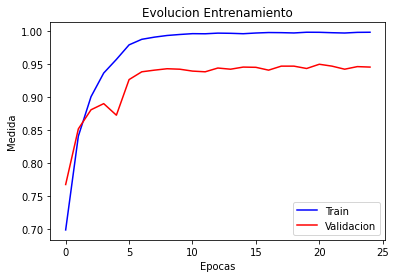

In [43]:
plt.plot(historico.history['accuracy'], c = 'b')
plt.plot(historico.history['val_accuracy'], c = 'r')
plt.legend(['Train', 'Validacion'])
plt.xlabel('Epocas')
plt.ylabel('Medida')
plt.title('Evolucion Entrenamiento')
plt.show()

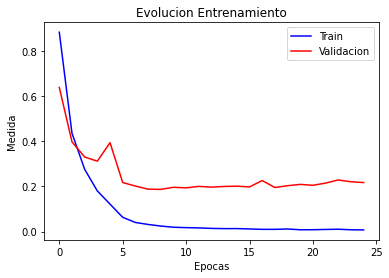

In [44]:
plt.plot(historico.history['loss'], c = 'b')
plt.plot(historico.history['val_loss'], c = 'r')
plt.legend(['Train', 'Validacion'])
plt.xlabel('Epocas')
plt.ylabel('Medida')
plt.title('Evolucion Entrenamiento')
plt.show()

In [45]:
metricas = model.evaluate(X_test, Y_test)

3/3 [==============================] - 0s 37ms/step - loss: 0.6288 - accuracy: 0.9080


In [46]:
y_pred = model.predict(X_test)

In [47]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

Confusion matrix, without normalization
[[ 1  0  0  1  0  0  0]
 [ 0  4  0  0  0  0  0]
 [ 0  3  6  0  0  0  0]
 [ 0  0  0  1  0  0  0]
 [ 0  0  0  0 57  1  2]
 [ 0  0  1  0  0  9  0]
 [ 0  0  0  0  0  0  1]]
Normalized confusion matrix
[[0.5  0.   0.   0.5  0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.  ]
 [0.   0.33 0.67 0.   0.   0.   0.  ]
 [0.   0.   0.   1.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.95 0.02 0.03]
 [0.   0.   0.1  0.   0.   0.9  0.  ]
 [0.   0.   0.   0.   0.   0.   1.  ]]


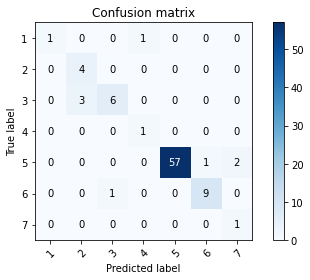

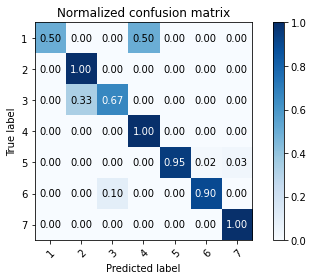

In [48]:
y = np.repeat(np.arange(0,10),15)
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    
    cm = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
    # Only use the labels that appear in the data
    classes = unique_labels([1,2,3,4,5,6,7], [1,2,3,4,5,6,7])
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()

    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(Y_test, y_pred, classes=7,
                      title='Confusion matrix')

# Plot normalized confusion matrix
plot_confusion_matrix(Y_test, y_pred, classes=7, normalize=True,
                      title='Normalized confusion matrix')

plt.show()